In [15]:
import math
import pandas as pd
import numpy as np
import torch
import seaborn as sn
import xgboost as xgb
from torch import nn
import matplotlib.pyplot as plt 
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

In [12]:
# use own model

df = pd.read_csv("data.csv")
df["pick"] = df["pick"].notnull().astype('int')
pick_df = df["pick"]
df = df.drop(["yr", "ht", "num", "ast/tov", "rimmade", "rimmade+rimmiss", "midmade", "midmade+midmiss", 
             "rimmade/(rimmade+rimmiss)", "midmade/(midmade+midmiss)", "dunksmade", "dunksmiss+dunksmade",
             "dunksmade/(dunksmade+dunksmiss)", "Unnamed: 64", "Unnamed: 65", "pick", "team", "conf", 
              "type", "year", "pid", "player_name"], axis=1)
df["Rec Rank"] = df["Rec Rank"].fillna(0)
df = df.dropna()

df = (df - df.min()) / (df.max() - df.min())
# scaler = MinMaxScaler()
# df[df.columns] = scaler.fit_transform(df[df.columns])

df["pick"] = pick_df
train_df, valid_df = train_test_split(df, test_size=0.2)
y_train_df = train_df["pick"]
y_valid_df = valid_df["pick"]
train_df = train_df.drop(["pick"], axis=1)
valid_df = valid_df.drop(["pick"], axis=1)

train_df.head()

/Users/ishaan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts
49638,0.750,0.285714,0.111271,0.264,0.358000,0.373533,0.002093,0.010181,0.064,0.270,...,0.231612,0.377152,0.561686,0.054371,0.125729,0.118280,0.04194,0.104850,0.049086,0.087907
38277,0.500,0.153061,0.111871,0.508,0.320000,0.325867,0.002981,0.008448,0.142,0.177,...,0.183810,0.383931,0.551688,0.064214,0.074237,0.082540,0.05714,0.047625,0.009053,0.132931
36125,0.800,0.113265,0.116427,0.330,0.276667,0.279800,0.010212,0.012924,0.058,0.194,...,0.107878,0.381813,0.561556,0.127686,0.078741,0.111113,0.02121,0.022725,0.017288,0.040281
59627,0.025,0.006122,0.093165,0.672,0.666667,0.512800,0.000000,0.024188,0.308,0.510,...,0.070000,0.360488,0.539394,0.000000,0.086614,0.066667,0.05000,0.000000,0.000000,0.049849
50918,0.675,0.478571,0.097962,0.228,0.272667,0.281867,0.003425,0.008448,0.031,0.203,...,0.394194,0.370491,0.559080,0.163096,0.167641,0.193547,0.04839,0.169350,0.122706,0.105058


[00:37:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----- XGB -----
Train Accuracy: 0.9985659264115382
Validation Accuracy: 0.981316069818897


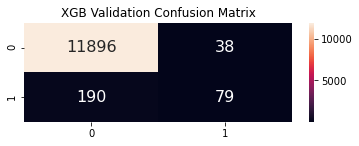

In [18]:
x_train = train_df.to_numpy()
y_train = y_train_df.to_numpy()
x_valid = valid_df.to_numpy()
y_valid = y_valid_df.to_numpy()

algo_mapping = {
        "GNB": GaussianNB(),
        "LR": LogisticRegression(max_iter=1000),
        "KNN": KNeighborsClassifier(),
        "LINEAR SVM": SVC(kernel = "linear", C=0.001, probability=True),
        "RBF SVM": SVC(gamma=2, C=1),
        "DT": DecisionTreeClassifier(),
        "BG": BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, n_estimators=100),
        "RF": RandomForestClassifier(n_estimators=100, max_depth=10),
        "ADB": AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10, max_depth=4), n_estimators=100, learning_rate=0.1),
        "GBC": GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=6),
        "XGB": xgb.XGBClassifier(colsample_bytree=0.2, learning_rate=0.3, max_depth=6, use_label_encoder=False),
        "EVC": VotingClassifier(estimators=[
            ("adb",AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10, max_depth=4), n_estimators=100, learning_rate=0.1),),
            ("gbc",GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=6),),
            ("xgb", xgb.XGBClassifier(colsample_bytree=0.2, learning_rate=0.3, max_depth=6, use_label_encoder=False))
        ], voting="hard"),
        "MLP": MLPClassifier(alpha=1, max_iter=1000),
    }

def score(name, algo, x_train, y_train, x_valid, y_valid):
    algo.fit(x_train, y_train.ravel())
    prediction = algo.predict(x_valid)
    print("-----", name, "-----")
    print("Train Accuracy:", algo.score(x_train, y_train))
    print("Validation Accuracy:", algo.score(x_valid, y_valid))

    cm = confusion_matrix(y_valid, prediction)
    df_cm = pd.DataFrame(cm)
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, ax=ax1, fmt='g').set_title(name + " Validation Confusion Matrix")
    
algos = ["XGB"]
for i in algos:
    score(i, algo_mapping[i], x_train, y_train, x_valid, y_valid)